In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.optimize import minimize

In [2]:
from modules import models
from modules import experiment as exp
from modules import plots
from modules import fitting
from modules import evaluation

/home/njvh/Documents/Science/gamma/kill-basic-hadronic-model/modules/../data


In [3]:
from importlib import reload
_ = reload(models)
_ = reload(exp)
_ = reload(plots)
_ = reload(evaluation)
_ = reload(fitting)

optimizing model...
optimization result: Optimization terminated successfully.
optimizing model...
optimization result: Optimization terminated successfully.
Akaike weights: Logparabola source + EBL absorption for 1ES1218+304 (shifts: 1.0, 1.0): 1.000000
Basic hadronic model for 1ES1218+304 (shifts: 1.0, 1.252070168163217): 0.000000

the best model is 1.4159205745369625e+51 times more probable given the data than the second

optimizing model...
optimization result: Optimization terminated successfully.
optimizing model...
optimization result: Optimization terminated successfully.
Akaike weights: Logparabola source + EBL absorption for 1ES1101-232 (shifts: 1.0, 1.0): 0.998622
Basic hadronic model for 1ES1101-232 (shifts: 1.0, 0.8362588574623027): 0.001378

the best model is 724.5808932981977 times more probable given the data than the second

optimizing model...
optimization result: Optimization terminated successfully.
optimizing model...
optimization result: Optimization terminated su

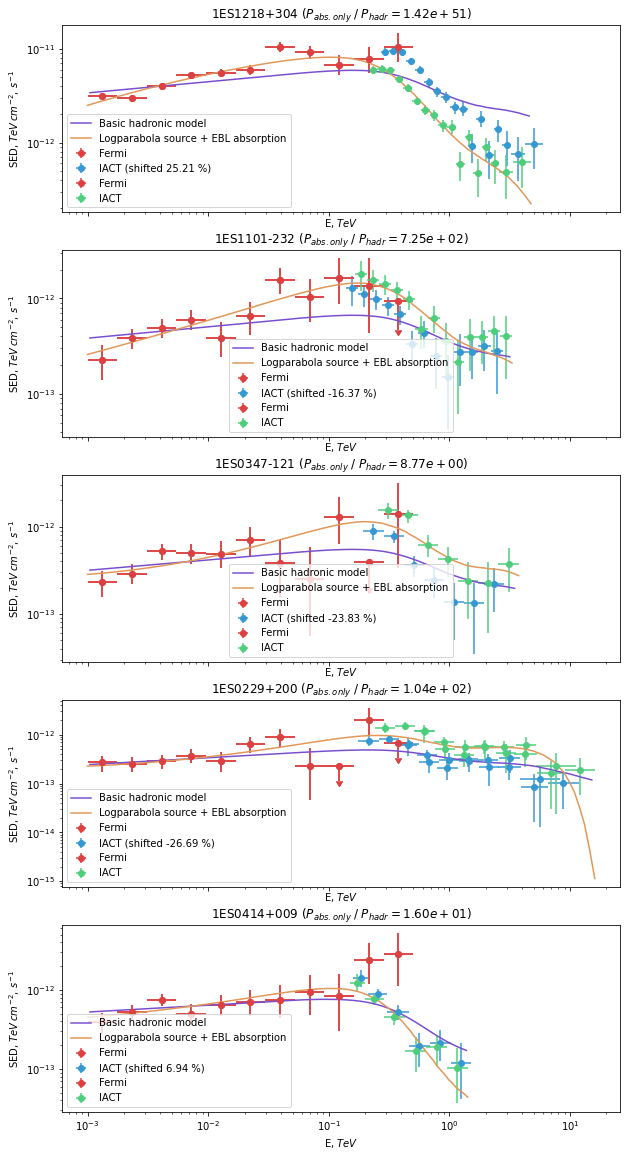

In [10]:
n_plots = len(exp.all_objects)
fig, axes = plt.subplots(nrows=n_plots, ncols=1, sharex=True, figsize=(10, n_plots*4))

for obj, ax in zip(exp.all_objects, axes):
# for obj, ax in zip([exp.all_objects[0]], [axes[0]]):
    obj_models = [
        models.BasicHadronicModelSED.at_z(obj.z),
        models.LogparabolaThroughEblSED.for_object(obj),
    ]
    exp_E_varying_configs = [
        fitting.ExpSedEnergyVaryingConfig.for_object(obj, default=True, fix=['Fermi']),
        fitting.ExpSedEnergyVaryingConfig.for_object(obj, default=False),
    ]

    shifted_objs = []

    for model, exp_E_varying in zip(obj_models, exp_E_varying_configs):
        model_params, E_factors = fitting.fit_model_to_object(
            obj, model, exp_E_varying=exp_E_varying
        )
        model.set_parameters(*model_params)
        shifted_objs.append(obj.with_E_factors(*E_factors))

    aw = evaluation.compare_models_for_objects(
        shifted_objs, obj_models, exp_E_varying_configs
    )

    prob_ratio = aw[0] / aw[1]
    print(f'\nthe best model is {prob_ratio} times more probable given the data than the second\n')

    # fig, ax = plt.subplots(figsize=(8, 6))

    for obj_shifted, model in zip(shifted_objs, obj_models):
        obj_shifted.plot(ax)
        model.plot(ax, obj.E_min, obj.E_max)

    ax.set_title(obj.name + f' ($P_{{abs. only}} \; / \; P_{{hadr}} = {prob_ratio:.2e}$)')
    ax.legend()


fig.savefig('./pics/object-wise-fits.pdf')